In [1]:
import tensorflow as tf
import keras
import os
import shutil
import cv2
import numpy as np
import glob as glob
import matplotlib.pyplot as plt
from keras.models import load_model

In [2]:
print(len(glob.glob("Evaluation/Test/**/*.jpg")))
print(len(glob.glob("Evaluation/Validation/**/*.jpg")))

394
917


In [3]:
train_dir = "Training"
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=16,
    image_size=(256, 256),
    shuffle=True,
    seed=123,
    interpolation='area'
)

valid_dir = "Evaluation/Validation"
val_ds = tf.keras.utils.image_dataset_from_directory(
    valid_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=16,
    image_size=(256, 256),
    shuffle=True,
    seed=123,
    interpolation='area'
)

Found 5712 files belonging to 4 classes.
Found 917 files belonging to 4 classes.


In [4]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))


# Load Densenet121


In [17]:
model = tf.keras.Sequential()

densenet_base = tf.keras.applications.DenseNet121(
    include_top=False,
    weights="imagenet",
    input_shape=(256,256,3),
)

for layer in densenet_base.layers:
    layer.trainable=False


model.add(densenet_base)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(4, activation='softmax'))

In [18]:
import segmentation_models_3D as sm
focal_loss = sm.losses.CategoricalFocalLoss()

In [19]:
epochs = 15
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

checkpoint =  tf.keras.callbacks.ModelCheckpoint(filepath ='model_checkpoints/densenet121_focal_loss.hdf5',
                                                 verbose=1,
                                                 monitor='val_loss',
                                                 mode='max'
                                                 )

# Define some callbacks to improve training.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)


In [20]:
history_densenet = model.fit(train_ds,
                          validation_data=val_ds,
                          epochs=epochs,
                          callbacks=[early_stopping, reduce_lr, checkpoint])

Epoch 1/15
357/357 [==============================] - ETA: 0s - loss: 0.3785 - accuracy: 0.8738
Epoch 1: saving model to model_checkpoints\densenet121_focal_loss.hdf5
357/357 [==============================] - 47s 117ms/step - loss: 0.3785 - accuracy: 0.8738 - val_loss: 0.2025 - val_accuracy: 0.9215 - lr: 1.0000e-04
Epoch 2/15
357/357 [==============================] - ETA: 0s - loss: 0.1102 - accuracy: 0.9587
Epoch 2: saving model to model_checkpoints\densenet121_focal_loss.hdf5
357/357 [==============================] - 41s 113ms/step - loss: 0.1102 - accuracy: 0.9587 - val_loss: 0.1216 - val_accuracy: 0.9477 - lr: 1.0000e-04
Epoch 3/15
357/357 [==============================] - ETA: 0s - loss: 0.0451 - accuracy: 0.9853
Epoch 3: saving model to model_checkpoints\densenet121_focal_loss.hdf5
357/357 [==============================] - 41s 113ms/step - loss: 0.0451 - accuracy: 0.9853 - val_loss: 0.0935 - val_accuracy: 0.9673 - lr: 1.0000e-04
Epoch 4/15
357/357 [==========================

In [21]:
densenet_base.trainable = True
# for layer in dens_base.layers[:25]:
#     layer.trainable=False
    
fine_tune_history_resnet50 = model.fit(train_ds,
                          validation_data=val_ds,
                          epochs=epochs,
                          callbacks=[early_stopping, reduce_lr, checkpoint])

Epoch 1/15
357/357 [==============================] - ETA: 0s - loss: 2.9836e-04 - accuracy: 1.0000
Epoch 1: saving model to model_checkpoints\densenet121_focal_loss.hdf5
357/357 [==============================] - 41s 114ms/step - loss: 2.9836e-04 - accuracy: 1.0000 - val_loss: 0.0735 - val_accuracy: 0.9771 - lr: 1.0000e-04
Epoch 2/15
357/357 [==============================] - ETA: 0s - loss: 2.5424e-04 - accuracy: 1.0000
Epoch 2: saving model to model_checkpoints\densenet121_focal_loss.hdf5
357/357 [==============================] - 41s 114ms/step - loss: 2.5424e-04 - accuracy: 1.0000 - val_loss: 0.0771 - val_accuracy: 0.9760 - lr: 1.0000e-04
Epoch 3/15
357/357 [==============================] - ETA: 0s - loss: 2.2219e-04 - accuracy: 1.0000
Epoch 3: saving model to model_checkpoints\densenet121_focal_loss.hdf5
357/357 [==============================] - 41s 113ms/step - loss: 2.2219e-04 - accuracy: 1.0000 - val_loss: 0.0788 - val_accuracy: 0.9749 - lr: 1.0000e-04
Epoch 4/15
357/357 [==

In [22]:
test_dir = "Evaluation/Test"
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=16,
    image_size=(256, 256),
    shuffle=True,
    seed=123,
    interpolation='area'
)
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
score = model.evaluate(test_ds)

Found 394 files belonging to 4 classes.
25/25 [==============================] - 4s 139ms/step - loss: 0.0358 - accuracy: 0.9873


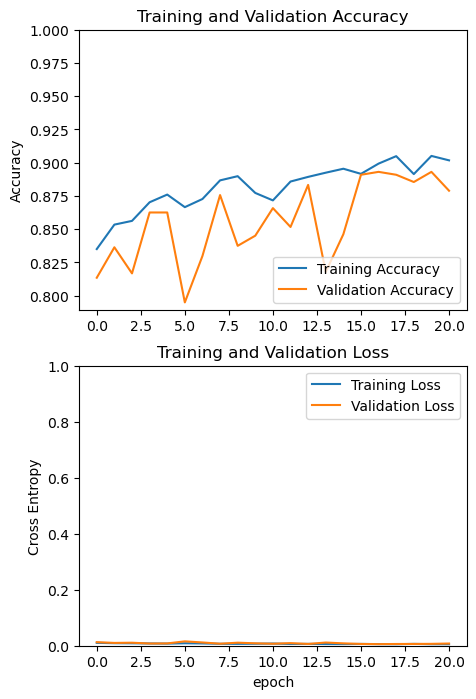

In [13]:
history = fine_tune_history_resnet50
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(5,8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,0.1])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()